In [1]:
%matplotlib notebook

import os
import shutil
import numpy as np
import covseisnet as cn
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import h5py
from models import UNet, CallBacks

from scipy.signal import tukey, butter, filtfilt
from scipy.stats import pearsonr

from time import time

from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

from bm3d import bm3d
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import numpy.ma as ma

In [2]:
def insert_str(string, str_to_insert, index):
    return string[:index] + str_to_insert + string[index:]
def suppr_str(string, index, number_to_suppr):
    temp= index+number_to_suppr
    return string[:index] + string[temp:]
def suppr_gaps(stream):
    for i in range(len(stream)):
        average = stream[i].data.mean()
        stream[i].data=ma.filled(stream[i].data,average)
    return stream
def merge_traces_data_together(stream,number):
    for i in range(0,640*number,number):
        stream[int(i/number)]=stream[i]
        for j in range(1,number):
            stream[int(i/number)]+=stream[i+j]
    for i in range(640):
        for j in range(number-1):
                stream.pop(640)
    return stream

In [3]:
def read_stream(name_of_folder):
    
    hollow_path = r"C:\Users\MFE\ansel\\ID.00000_20210701.mseed"
    path = insert_str(hollow_path,name_of_folder,19)
    hollow_path1= suppr_str(path,42,1)
    hollow_path2= suppr_str(hollow_path1,42,1)
    hollow_path3= suppr_str(hollow_path2,42,1)
    stream = cn.arraystream.read(path)
    for i in range(9):
        temp_path = insert_str(hollow_path1,str(i+1),46)
        print(temp_path)
        stream += cn.arraystream.read(temp_path)
    for i in range(10,100):
        temp_path = insert_str(hollow_path2,str(i),45)
        stream += cn.arraystream.read(temp_path)
    for i in range(100,640):
        temp_path = insert_str(hollow_path3,str(i),44)
        stream += cn.arraystream.read(temp_path)
    return stream

In [4]:
stream1 =read_stream('20210701_T062219.81')
#stream2 =read_stream('20210701_T062239.81')
#stream3 =read_stream('20210701_T062259.81')
#stream4 =read_stream('20210701_T062319.81')
#stream5 =read_stream('20210701_T062339.81')
#stream6 =read_stream('20210701_T062359.81')
#stream7 =read_stream('20210701_T062419.81')
print(stream1)
#print(stream2)
#print(stream3)
#goal: create an array containing all the data of the stream
#size=39*7,len(stream1),2048
#data_total=np.zeros(size,dtype=np.float32)
#for i in range(len(stream1)):
#    for j in range(39):
#        data_total[j][i]=stream1[i][2048*j:2048*(j+1)]
#        data_total[39+j][i]=stream2[i][2048*j:2048*(j+1)]
#        data_total[2*39+j][i]=stream3[i][2048*j:2048*(j+1)]
#        data_total[3*39+j][i]=stream4[i][2048*j:2048*(j+1)]
#        data_total[4*39+j][i]=stream5[i][2048*j:2048*(j+1)]
#        data_total[5*39+j][i]=stream6[i][2048*j:2048*(j+1)]
#        data_total[6*39+j][i]=stream7[i][2048*j:2048*(j+1)]
# create an array containg the 3 streams ( used to register the reconstruction )

C:\Users\MFE\ansel\20210701_T062219.81\ID.00001_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00002_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00003_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00004_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00005_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00006_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00007_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00008_20210701.mseed
C:\Users\MFE\ansel\20210701_T062219.81\ID.00009_20210701.mseed
640 Trace(s) in Stream:

ID.00000..HSF | 2021-07-01T06:22:19.033500Z - 2021-07-01T06:22:39.028250Z | 4000.0 Hz, 79980 samples
...
(638 other traces)
...
ID.00639..HSF | 2021-07-01T06:22:19.033500Z - 2021-07-01T06:22:39.028250Z | 4000.0 Hz, 79980 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


In [5]:
#for i in range(data_total.shape[1]):
#    for j in range(data_total.shape[0]):
#        data_total[j][i]=data_total[j][i]/data_total[j][i].std()
#print(data_total[5][2][0:5])

In [14]:
cwd = os.getcwd()
N_ch, N_t = (640,2048)
data_dir = os.path.join(cwd, "reconstruction_snr_1_clean_inputs_big_model")
data_recs = np.zeros((273,N_ch,N_t))
for i in range(273):
    data_rec_file = os.path.join(data_dir, f"reconstruction_{i}.h5")
    with h5py.File(data_rec_file, "r") as h5f:
        data_recs[i] = h5f["strain_rate"][...]

In [15]:
print(data_recs.shape)

(273, 640, 2048)


In [16]:
stats=obspy.core.trace.Stats()
stats.sampling_rate=4000
stats.starttime=stream1[0].stats.starttime
stats.npts=2048*39*7
print(stats.starttime)
print(stats.endtime)

2021-07-01T06:22:19.033500Z
2021-07-01T06:24:38.809250Z


In [17]:
size_final=1,640,2048*39*7
#data_original = np.zeros(size_final)
data_reconstructed = np.zeros(size_final)
for i in range(39*7):
   # data_original[0,0:640,2048*i:2048*(i+1)]=data_total[i,0:640]
    data_reconstructed[0,0:640,2048*i:2048*(i+1)]=data_recs[i,0:640]

In [23]:
#st_total = obspy.Stream(traces=None)
st_recs = obspy.Stream(traces=None)
for i in range(len(data_reconstructed[0])):
    #tr_total = obspy.core.trace.Trace(data=data_original[0][i], header=stats)
    tr_recs = obspy.core.trace.Trace(data=data_reconstructed[0][i], header=stats)
    #st_total.append(tr_total)
    st_recs.append(tr_recs)
#print(st_total[0].stats.starttime)
#print(st_total[0].stats.endtime)

<IPython.core.display.Javascript object>


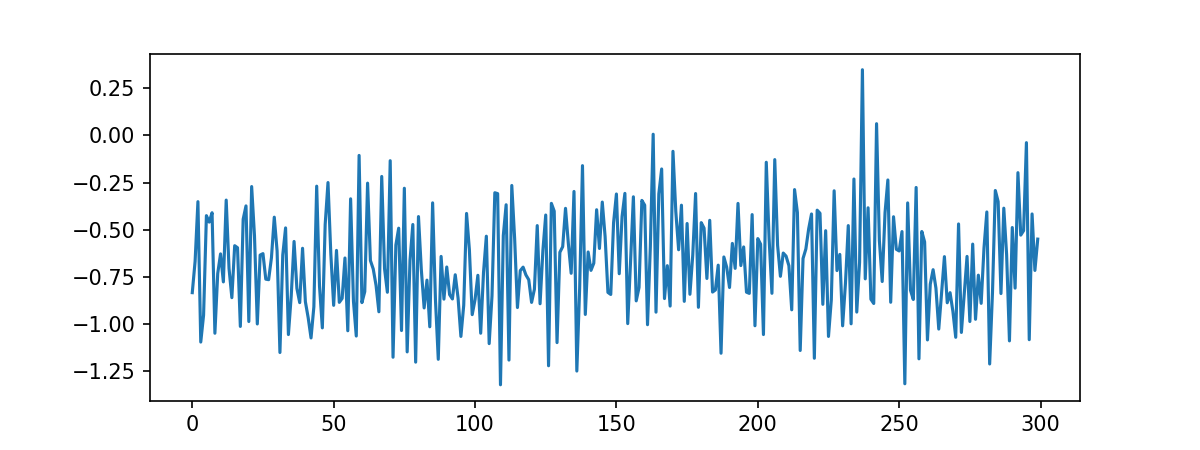

In [24]:
fig = plt.figure(figsize=(8, 3), dpi=150)
plt.plot(st_recs[310][500+4*2048:800+4*2048])

In [25]:
import obspy
from obspy.signal.filter import bandpass

def create_covariance_matrix(stream, window_duration_sec, average, name):
    # Calculate covariance matrix for the filtered stream
    times, frequencies, covariances = cn.covariancematrix.calculate(stream, window_duration_sec, average)
    spectral_width = covariances.coherence(kind="spectral_width")

    # Plot and save the result
    fig, ax = plt.subplots(1, constrained_layout=True, facecolor=(1, 1, 1))
    img = ax.pcolormesh(times, frequencies, spectral_width.T, rasterized=True, cmap="viridis_r")
    ax.set_ylim([0, stream[0].stats.sampling_rate/2])
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Frequency (Hz)")
    plt.colorbar(img).set_label("Covariance matrix spectral width")
    fig.savefig(name)

<IPython.core.display.Javascript object>


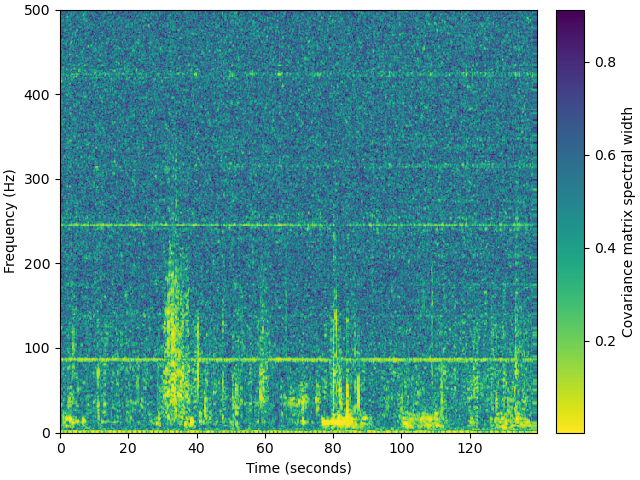

In [26]:
st_recs.decimate(4)
channels=280
create_covariance_matrix(st_recs[channels+0:channels+40:2],0.5,3,"cov_noisy_data_reconstructed_bigger_model")